# Step-by-Step: Gradient Boosting (GBM)


## 1. Import Libraries


In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from math import log, exp
from IPython.display import display
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import GradientBoostingClassifier
from PIL import Image
import graphviz, re, os

## 2. Dataset & Helpers


In [5]:
xs = np.array([1,2,3,4], dtype=float)
y_reg = np.array([2,3,5,6], dtype=float)
y_bin = np.array([0,0,1,1], dtype=float)

def sigmoid(z):
  return 1.0/(1.0+np.exp(-z))

def r2(x):
  return float(f"{x:.2f}")

## 3. GBM Binary Classification (Logistic)

In [16]:
def gbm_logistic_two_rounds(xs, y_bin, match_writeup_rounding=True):
    print("\nBinary Classification\n")
    # Bước 1 — Khởi tạo
    pbar = float(y_bin.mean())
    F0 = 0.0
    p0 = np.array([sigmoid(F0) for _ in xs])
    print(f"Bước 1 — Khởi tạo: p̄ = {r2(pbar)}, F0 = 0, p0 = {[r2(v) for v in p0]}")

    # Loss ban đầu
    losses0 = [-(y*log(p)+(1-y)*log(1-p)) for y,p in zip(y_bin,p0)]
    L0 = sum(losses0)
    print(f"Loss từng điểm (L0): {[r2(v) for v in losses0]}")
    print(f"Tổng loss L0 = {r2(L0)}")

    # Vòng 1 — Newton-like
    print("\nBước 2 — Vòng 1:")
    r1 = y_bin - p0
    print(f"Residual r1 = {[f'{v:+.2f}' for v in r1]}")
    t1 = 2.5
    L = xs < t1; R = xs >= t1
    sum_r_L = float(r1[L].sum()); sum_r_R = float(r1[R].sum())
    sum_pq_L = float((p0[L]*(1-p0[L])).sum()); sum_pq_R = float((p0[R]*(1-p0[R])).sum())
    g1L = sum_r_L / sum_pq_L
    g1R = sum_r_R / sum_pq_R
    print(f"Ngưỡng x < {t1}")
    print(f"  Σr_left={r2(sum_r_L)}, Σ[p(1-p)]_left={r2(sum_pq_L)} => gamma_left={r2(g1L)}")
    print(f"  Σr_right={r2(sum_r_R)}, Σ[p(1-p)]_right={r2(sum_pq_R)} => gamma_right={r2(g1R)}")

    def stump_val1(x):
        return g1L if x < t1 else g1R
    F1 = np.array([F0 + stump_val1(x) for x in xs])
    p1_exact = sigmoid(F1)
    print(f"F1(x_i) = {[r2(v) for v in F1]}")
    print(f"p1(x_i) = {[r2(v) for v in p1_exact]} (exact)")

    # Loss vòng 1
    losses1 = [-(y*log(p)+(1-y)*log(1-p)) for y,p in zip(y_bin,p1_exact)]
    L1 = sum(losses1)
    print(f"Loss từng điểm (L1): {[r2(v) for v in losses1]}")
    print(f"Tổng loss L1 = {r2(L1)}")

    # Vòng 2 — giữ ngưỡng 2.5
    print("\nBước 3 — Vòng 2:")
    if match_writeup_rounding:
        p1 = np.array([0.12 if x < t1 else 0.88 for x in xs])
        print("  (Dùng p1 ≈ 0.12 (trái) và 0.88 (phải))")
    else:
        p1 = p1_exact.copy(); print("  (Dùng p1 exact)")
    r2v = y_bin - p1
    print(f"Residual r2 = {[f'{v:+.2f}' for v in r2v]}")
    t2 = 2.5
    L2 = xs < t2; R2 = xs >= t2
    sum_r_L2 = float(r2v[L2].sum()); sum_r_R2 = float(r2v[R2].sum())
    sum_pq_L2 = float((p1[L2]*(1-p1[L2])).sum()); sum_pq_R2 = float((p1[R2]*(1-p1[R2])).sum())
    g2L = sum_r_L2 / sum_pq_L2
    g2R = sum_r_R2 / sum_pq_R2
    print(f"Ngưỡng x < {t2}")
    print(f"  Σr_left={r2(sum_r_L2)}, Σ[p(1-p)]_left={r2(sum_pq_L2)} => gamma_left_2={r2(g2L)}")
    print(f"  Σr_right={r2(sum_r_R2)}, Σ[p(1-p)]_right={r2(sum_pq_R2)} => gamma_right_2={r2(g2R)}")

    def stump_val2(x):
        return g2L if x < t2 else g2R
    F2 = np.array([F1[i] + stump_val2(xs[i]) for i in range(len(xs))])
    p2 = sigmoid(F2)
    print(f"F2(x_i) = {[r2(v) for v in F2]}")
    print(f"p2(x_i) = {[r2(v) for v in p2]}")
    yhat = [1 if p>=0.5 else 0 for p in p2]
    print(f"Nhãn dự đoán: {yhat}")

    # Loss vòng 2
    losses2 = [-(y*log(p)+(1-y)*log(1-p)) for y,p in zip(y_bin,p2)]
    L2 = sum(losses2)
    print(f"Loss từng điểm (L2): {[r2(v) for v in losses2]}")
    print(f"Tổng loss L2 = {r2(L2)}")

    return {
        'F0':F0, 'F1':F1, 'F2':F2,
        'p0':p0, 'p1':p1_exact, 'p2':p2,   # thêm p1
        't1':t1, 't2':t2,
        'g1L':g1L, 'g1R':g1R, 'g2L':g2L, 'g2R':g2R,
        'yhat':yhat,
        'loss0':L0, 'loss1':L1, 'loss2':L2
    }

logi = gbm_logistic_two_rounds(xs, y_bin, match_writeup_rounding=True)


Binary Classification

Bước 1 — Khởi tạo: p̄ = 0.5, F0 = 0, p0 = [0.5, 0.5, 0.5, 0.5]
Loss từng điểm (L0): [0.69, 0.69, 0.69, 0.69]
Tổng loss L0 = 2.77

Bước 2 — Vòng 1:
Residual r1 = ['-0.50', '-0.50', '+0.50', '+0.50']
Ngưỡng x < 2.5
  Σr_left=-1.0, Σ[p(1-p)]_left=0.5 => gamma_left=-2.0
  Σr_right=1.0, Σ[p(1-p)]_right=0.5 => gamma_right=2.0
F1(x_i) = [-2.0, -2.0, 2.0, 2.0]
p1(x_i) = [0.12, 0.12, 0.88, 0.88] (exact)
Loss từng điểm (L1): [0.13, 0.13, 0.13, 0.13]
Tổng loss L1 = 0.51

Bước 3 — Vòng 2:
  (Dùng p1 ≈ 0.12 (trái) và 0.88 (phải))
Residual r2 = ['-0.12', '-0.12', '+0.12', '+0.12']
Ngưỡng x < 2.5
  Σr_left=-0.24, Σ[p(1-p)]_left=0.21 => gamma_left_2=-1.14
  Σr_right=0.24, Σ[p(1-p)]_right=0.21 => gamma_right_2=1.14
F2(x_i) = [-3.14, -3.14, 3.14, 3.14]
p2(x_i) = [0.04, 0.04, 0.96, 0.96]
Nhãn dự đoán: [0, 0, 1, 1]
Loss từng điểm (L2): [0.04, 0.04, 0.04, 0.04]
Tổng loss L2 = 0.17


In [19]:
# Compare result with Sklearn GBM Logistic Library

# -------- Manual GBM Logistic --------
def gbm_logistic_two_rounds(xs,y_bin):
    # init
    F0 = 0.0
    p0 = np.array([sigmoid(F0)]*len(xs))
    L0 = sum([-(y*log(p)+(1-y)*log(1-p)) for y,p in zip(y_bin,p0)])

    # round1
    r1 = y_bin - p0
    thr=2.5
    L,R=xs<thr,xs>=thr
    g1L=(r1[L].sum())/((p0[L]*(1-p0[L])).sum())
    g1R=(r1[R].sum())/((p0[R]*(1-p0[R])).sum())
    F1=np.array([F0+(g1L if x<thr else g1R) for x in xs])
    p1=sigmoid(F1)
    L1=sum([-(y*log(p)+(1-y)*log(1-p)) for y,p in zip(y_bin,p1)])

    # round2
    r2v=y_bin-p1
    g2L=(r2v[L].sum())/((p1[L]*(1-p1[L])).sum())
    g2R=(r2v[R].sum())/((p1[R]*(1-p1[R])).sum())
    F2=np.array([F1[i]+(g2L if xs[i]<thr else g2R) for i in range(len(xs))])
    p2=sigmoid(F2)
    L2=sum([-(y*log(p)+(1-y)*log(1-p)) for y,p in zip(y_bin,p2)])
    yhat=(p2>=0.5).astype(int)

    return {"F0":F0,"p0":p0,"F1":F1,"p1":p1,"F2":F2,"p2":p2,
            "loss0":L0,"loss1":L1,"loss2":L2,"yhat":yhat}

manual = gbm_logistic_two_rounds(xs,y_bin)

print("=== Logistic GBM (tính tay) ===")
print("Khởi tạo: F0=0, p0=", np.round(manual["p0"],3), "Loss0=", r2(manual["loss0"]))
print("Vòng1: F1=", np.round(manual["F1"],3), "p1=", np.round(manual["p1"],3), "Loss1=", r2(manual["loss1"]))
print("Vòng2: F2=", np.round(manual["F2"],3), "p2=", np.round(manual["p2"],3), "Loss2=", r2(manual["loss2"]))
print("Predict label:", manual["yhat"])

# -------- Sklearn GBM Logistic --------
print("\n=== Logistic GBM (sklearn) ===")
gb_clf=GradientBoostingClassifier(
    loss="log_loss",learning_rate=1.0,n_estimators=2,max_depth=1,random_state=0
)
gb_clf.fit(xs.reshape(-1,1),y_bin)
p_pred=gb_clf.predict_proba(xs.reshape(-1,1))[:,1]
y_pred=gb_clf.predict(xs.reshape(-1,1))

print("Predict proba:", p_pred.round(3))
print("Predict label:", y_pred)

# -------- so sánh--------
df=pd.DataFrame({
    "x":xs,
    "y_true":y_bin,
    "p2_manual":manual["p2"],
    "p2_sklearn":p_pred,
    "ŷ_manual":manual["yhat"],
    "ŷ_sklearn":y_pred
})
print("\n=== So sánh Manual vs Sklearn ===")
print(df.round(3))

=== Logistic GBM (tính tay) ===
Khởi tạo: F0=0, p0= [0.5 0.5 0.5 0.5] Loss0= 2.77
Vòng1: F1= [-2. -2.  2.  2.] p1= [0.119 0.119 0.881 0.881] Loss1= 0.51
Vòng2: F2= [-3.135 -3.135  3.135  3.135] p2= [0.042 0.042 0.958 0.958] Loss2= 0.17
Predict label: [0 0 1 1]

=== Logistic GBM (sklearn) ===
Predict proba: [0.042 0.042 0.958 0.958]
Predict label: [0. 0. 1. 1.]

=== So sánh Manual vs Sklearn ===
     x  y_true  p2_manual  p2_sklearn  ŷ_manual  ŷ_sklearn
0  1.0     0.0      0.042       0.042         0        0.0
1  2.0     0.0      0.042       0.042         0        0.0
2  3.0     1.0      0.958       0.958         1        1.0
3  4.0     1.0      0.958       0.958         1        1.0


## 4. Visualization

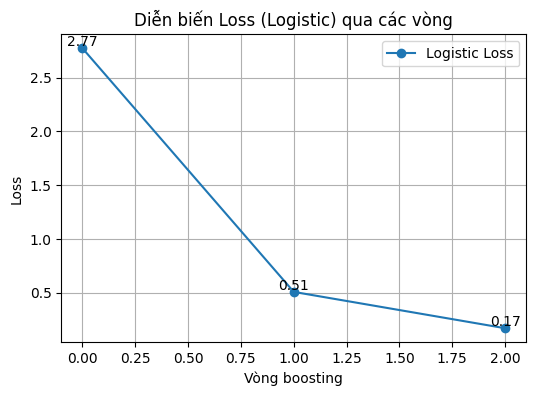

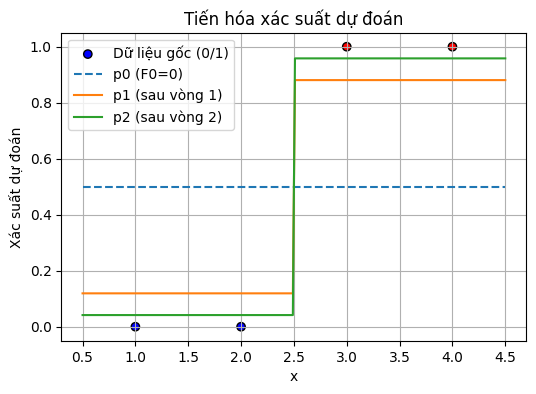

,x,y,F1,p1,Loss_1,F2,p2,Loss_2,ŷ
0,1.0,0.0,-2.0,0.119,0.508,-3.136,0.042,0.17,0
1,2.0,0.0,-2.0,0.119,0.508,-3.136,0.042,0.17,0
2,3.0,1.0,2.0,0.881,0.508,3.136,0.958,0.17,1
3,4.0,1.0,2.0,0.881,0.508,3.136,0.958,0.17,1


In [ ]:
# ===== Visualization =====
def visualize_logistic(xs, y_bin, logi):
    # 1. Loss qua từng vòng
    rounds = [0,1,2]
    losses = [logi['loss0'].sum(), logi['loss1'].sum(), logi['loss2'].sum()]
    plt.figure(figsize=(6,4))
    plt.plot(rounds, losses, marker='o', label="Logistic Loss")
    for i,v in enumerate(losses):
        plt.text(rounds[i], v+0.02, f"{v:.2f}", ha="center")
    plt.xlabel("Vòng boosting")
    plt.ylabel("Loss")
    plt.title("Diễn biến Loss (Logistic) qua các vòng")
    plt.grid(True); plt.legend(); plt.show()

    # 2. Xác suất dự đoán p0, p1, p2
    xgrid = np.linspace(0.5, 4.5, 200)
    def F1_grid(x): return logi['g1L'] if x < 2.5 else logi['g1R']
    def F2_grid(x): return F1_grid(x) + (logi['g2L'] if x < 2.5 else logi['g2R'])

    p0_grid = np.full_like(xgrid, 0.5)
    p1_grid = sigmoid(np.array([F1_grid(x) for x in xgrid]))
    p2_grid = sigmoid(np.array([F2_grid(x) for x in xgrid]))

    plt.figure(figsize=(6,4))
    plt.scatter(xs, y_bin, c=y_bin, cmap="bwr", edgecolor="k", label="Dữ liệu gốc (0/1)")
    plt.plot(xgrid, p0_grid, "--", label="p0 (F0=0)")
    plt.plot(xgrid, p1_grid, label="p1 (sau vòng 1)")
    plt.plot(xgrid, p2_grid, label="p2 (sau vòng 2)")
    plt.xlabel("x"); plt.ylabel("Xác suất dự đoán")
    plt.title("Tiến hóa xác suất dự đoán")
    plt.legend(); plt.grid(True); plt.show()

    # 3. Bảng tổng hợp
    df = pd.DataFrame({
        "x": xs,
        "y": y_bin,
        "F1": logi['F1'], "p1": logi['p1'], "Loss_1": logi['loss1'],
        "F2": logi['F2'], "p2": logi['p2'], "Loss_2": logi['loss2'],
        "ŷ": logi['yhat']
    })
    display(df.round(3))

visualize_logistic(xs, y_bin, logi)

## 5. Decision Stumps

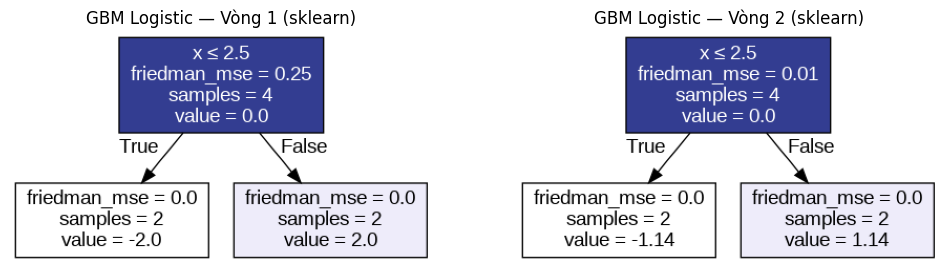

In [13]:
def export_tree_custom(estimator, filename):
    dot = export_graphviz(
        estimator, out_file=None, feature_names=["x"],
        filled=True, rounded=True, special_characters=True, precision=2
    )
    dot = re.sub(r'(0 \[label=.*?), fillcolor=.*?\]',
                 r'\1, style=filled, fillcolor="#333D91", fontcolor="white"]', dot)
    dot = re.sub(r'(1 \[label=.*?), fillcolor=.*?\]',
                 r'\1, style=filled, fillcolor="#FFFFFF", fontcolor="black"]', dot)
    dot = re.sub(r'(2 \[label=.*?), fillcolor=.*?\]',
                 r'\1, style=filled, fillcolor="#EEECFA", fontcolor="black"]', dot)
    g=graphviz.Source(dot); g.render(filename,format="png",cleanup=False)
    return filename+".png"

tree1 = gb_clf.estimators_[0,0]
tree2 = gb_clf.estimators_[1,0]
f1=export_tree_custom(tree1,"gbm_logi_round1")
f2=export_tree_custom(tree2,"gbm_logi_round2")

fig,axes=plt.subplots(1,2,figsize=(12,4))
for ax,f,t in zip(axes,[f1,f2],["GBM Logistic — Vòng 1 (sklearn)","GBM Logistic — Vòng 2 (sklearn)"]):
    ax.imshow(Image.open(f)); ax.axis("off"); ax.set_title(t,fontsize=12)
plt.show()